# Спортивные сообщества VK

## _"Определить вид спорта по посту" (Задача классификации)_


Данные: https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification

## Часть 0. Введение

### Обзор

Данный датасет, как мы увидим здесь состоит из 3 колонок и 38740 строк.

**Метаданные**

* **oid** - id сообщества
* **category** - вид спорта (таргет)
* **text** - текст поста

### Контекст:
На основе заданного набора постов определите, какой вид спорта обсуждается в выбранном сообществе.

**Список категорий**

    1.athletics,
    2.autosport,
    3.basketball,
    4.boardgames,
    5.esport,
    6.extreme,
    7.football,
    8.hockey,
    9.martial arts,
    10.motosport,
    11.tennis,
    12.volleyball,
    13.winter_sport
    
### Оценочная метрика:

In [ ]:
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples

## Часть 1: Импорт, загрузка данных

### Загрузка библиотек

In [212]:
import pandas as pd
import numpy as np

import re

from collections import Counter


### Загрузка данных в датафрейм vk_sport

In [243]:
vk_sport = pd.read_csv('train.csv', encoding_errors = 'ignore')

## Часть 2. Анализ данных (EDA)

In [244]:
vk_sport.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [160]:
vk_sport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38740 entries, 0 to 38739
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oid       38740 non-null  int64 
 1   category  38740 non-null  object
 2   text      38740 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.1+ KB


В таблице 3 колонки и 38740 строк.  
2 типа данных int64(1 колонка) и object(2 колонки)  
Пропущенных значений нет

In [161]:
vk_sport.describe(include=[object])

,category,text
count,38740,38740
unique,13,35774
top,autosport,За кроссовками в Баскетбольный магазин Ghetto ...
freq,3160,163


В колонке category - 13 уникальных значений.  
В колонке text - есть дублирующие тексты

In [162]:
# количество уникальных сообществ
vk_sport.oid.nunique()

3874

In [163]:
# есть ли сообщества с несколькими категориями?
vk_sport.groupby('oid').category.nunique().to_frame().query('category>1')

,category
oid,


Все сообщества в данном датасете имеют по одной категории

In [164]:
print('Количество классов:', vk_sport.category.nunique())
print('Распределение количества строк по категориям:')
vk_sport.category.value_counts()

Количество классов: 13
Распределение количества строк по категориям:


autosport       3160
extreme         3110
martial_arts    3050
motosport       3030
boardgames      3020
tennis          3000
esport          2990
athletics       2970
hockey          2950
volleyball      2950
football        2860
basketball      2850
winter_sport    2800
Name: category, dtype: int64

<AxesSubplot:>

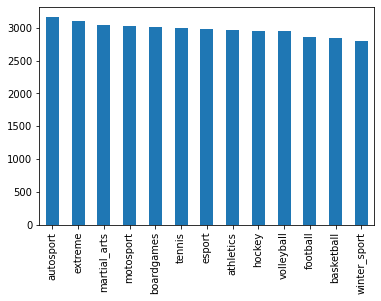

In [245]:
# визуализация распределения таргета "category"
vk_sport['category'].value_counts().plot(x = vk_sport['category'], kind='bar')

Имеем сбалансированный датасет

### Анализ колонки 'text'

In [240]:
# посмотрим на пример текста
vk_sport.at [23171,'text']

'Твое лицо когда написал слишком большой текст Всем йоу 33 С вами Игорь. Мы прямо сейчас колбасим с Димоном монтаж Почему велосипеды такие дорогие. Выпустить хотим 12го числа. 15 страниц текста смены локаций интервьюхи шуточки Крест Очкарик и черновик на 50 минут. . . Давно мы не делали настолько замороченной душнины. Может даже никогда. Поэтому с вас в обязательном порядке посмотреть. Вангую что либо очень понравится либо очень не понравится. А еще мы вкорячили сюда аж три рекламных интеграции но каждая из них несет смысл и дополняет сценарий. Возможно даже они вам зайдут. Кароч мы продолжим в ужасе колбасить а вы запаситесь вкусняхами или помидорами обнял приподнял убежал RADАнонс'

In [166]:
vk_sport.at [32619,'category']

'autosport'

In [239]:
vk_sport[vk_sport.text.str.contains('RAD')]

,oid,category,text,clean_text
1134,827878679,extreme,RAD Show возвращается 33 В новом выпуске чемпи...,rad show возвращается в новом выпуске чемпи...
4782,892798849,extreme,Полезное Калькулятор давления в покрышках от S...,полезное калькулятор давления в покрышках от s...
5861,197500793,extreme,Привет RAD хочу купить втулки что лучше? Катат...,привет rad хочу купить втулки что лучше катат...
6693,892798849,extreme,Привет RAD собрал себе хардтейл с амортизирующ...,привет rad собрал себе хардтейл с амортизирующ...
7099,201841889,extreme,Приветсвую сообщество RAD. Во время очередной ...,приветсвую сообщество rad во время очередной ...
10922,825367288,extreme,Привет RADовчане такой вопрос есть желание соб...,привет radовчане такой вопрос есть желание соб...
17497,825367288,extreme,Привет RAD 33 Посоветуйте хорошие толстые цепк...,привет rad посоветуйте хорошие толстые цепк...
19118,627910585,extreme,Привет RAD 33 Нужен совет 33 Хочу купить новый...,привет rad нужен совет хочу купить новый...
23171,184205944,extreme,Твое лицо когда написал слишком большой текст ...,твое лицо когда написал слишком большой текст ...
23720,330944968,extreme,Здраствуй RAD. Я купил подседельный штырь на ч...,здраствуй rad я купил подседельный штырь на ч...


Приведем текст к общему виду:
 - переводим символы в нижний регистр
 - удалим все слова цифры, пунктуацию и слова содержащие подстроку 'tokenoid'(видимо зашифрованы ссылки)

In [236]:
def prepose_text(text):
    text = text.lower()
    # убираем ссылки
    clean_text = re.sub(r"([a-z0-9]+)?tokenoid([a-z0-9]+)?", " ", text)
    # оставляем только буквенные символы
    clean_text = re.sub("[^а-яa-z]"," ", clean_text)
    return clean_text

vk_sport['clean_text'] = vk_sport['text'].map(prepose_text)

In [188]:
def text_to_wordlist(text, remove_stopwords=False ):
    # убираем ссылки
    clean_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
    # оставляем только буквенные символы
    clean_text = re.sub("[^а-яА-Я]"," ", review_text)
    # приводим к нижнему регистру и разбиваем на слова
    words = word_tokenize(review_text.lower(), language='russian')
    if remove_stopwords: # убираем стоп-слова
        words = [w for w in words if not w in remove_stopwords]

    lemma_words = [m.parse(w)[0].normal_form for w in words]

    if remove_stopwords: # убираем стоп-слова
        lemma_words_nostops = [w for w in lemma_words if not w in remove_stopwords]

    return(lemma_words_nostops)

## Разделим данные на тренировочные, валидационные и тестовые

In [197]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(vk_sport, test_size=0.2, random_state=42)
train, test = train_test_split(train, test_size=0.2, random_state=42)


In [198]:
print(f'Размеры train={train.shape[0]}, valid={valid.shape[0]} и test={test.shape[0]}')

Размеры train=24793, valid=7748 и test=6199


In [199]:
train.describe(include=[object])

,category,text
count,24793,24793
unique,13,23416
top,autosport,За кроссовками в Баскетбольный магазин Ghetto ...
freq,1994,93


In [169]:
# удалим полные дубликаты
train_drop_duplicates = train.drop_duplicates (['text'])

In [206]:
from sklearn.naive_bayes import MultinomialNB

mnb_ppl_clf = Pipeline([
   ('tfidf', TfidfVectorizer()),
   ('clf', MultinomialNB()),
 ])

mnb_ppl_clf.fit(train['text'], train['category'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [207]:
predicted_sgd = mnb_ppl_clf.predict(valid['text'])
print(metrics.classification_report(predicted_sgd, valid['category']))

              precision    recall  f1-score   support

   athletics       0.94      0.75      0.83       679
   autosport       0.86      0.70      0.77       805
  basketball       0.79      0.96      0.87       462
  boardgames       0.96      0.78      0.86       739
      esport       0.68      0.87      0.76       460
     extreme       0.76      0.65      0.70       736
    football       0.63      0.91      0.74       407
      hockey       0.82      0.85      0.83       602
martial_arts       0.67      0.84      0.75       464
   motosport       0.89      0.82      0.85       671
      tennis       0.93      0.94      0.94       603
  volleyball       0.82      0.81      0.82       607
winter_sport       0.80      0.87      0.83       513

    accuracy                           0.81      7748
   macro avg       0.81      0.83      0.81      7748
weighted avg       0.83      0.81      0.81      7748



In [200]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=15))])
sgd_ppl_clf.fit(train['text'], train['category'])
knb_ppl_clf.fit(train['text'], train['category'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=15))])

In [201]:
predicted_sgd = knb_ppl_clf.predict(valid['text'])
print(metrics.classification_report(predicted_sgd, valid['category']))

              precision    recall  f1-score   support

   athletics       0.89      0.65      0.75       745
   autosport       0.75      0.78      0.77       626
  basketball       0.81      0.79      0.80       574
  boardgames       0.91      0.87      0.89       625
      esport       0.66      0.77      0.71       507
     extreme       0.60      0.74      0.66       517
    football       0.67      0.79      0.72       494
      hockey       0.75      0.79      0.77       593
martial_arts       0.63      0.80      0.71       461
   motosport       0.88      0.71      0.79       778
      tennis       0.93      0.79      0.86       716
  volleyball       0.78      0.73      0.75       640
winter_sport       0.75      0.89      0.81       472

    accuracy                           0.77      7748
   macro avg       0.77      0.78      0.77      7748
weighted avg       0.79      0.77      0.77      7748



In [202]:
predicted_sgd = knb_ppl_clf.predict(valid['text'])
print(metrics.classification_report(predicted_sgd, valid['category']))

              precision    recall  f1-score   support

   athletics       0.89      0.65      0.75       745
   autosport       0.75      0.78      0.77       626
  basketball       0.81      0.79      0.80       574
  boardgames       0.91      0.87      0.89       625
      esport       0.66      0.77      0.71       507
     extreme       0.60      0.74      0.66       517
    football       0.67      0.79      0.72       494
      hockey       0.75      0.79      0.77       593
martial_arts       0.63      0.80      0.71       461
   motosport       0.88      0.71      0.79       778
      tennis       0.93      0.79      0.86       716
  volleyball       0.78      0.73      0.75       640
winter_sport       0.75      0.89      0.81       472

    accuracy                           0.77      7748
   macro avg       0.77      0.78      0.77      7748
weighted avg       0.79      0.77      0.77      7748



In [203]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=15))])
sgd_ppl_clf.fit(train_drop_duplicates['text'], train_drop_duplicates['category'])
knb_ppl_clf.fit(train_drop_duplicates['text'], train_drop_duplicates['category'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=15))])

In [174]:
predicted_sgd = sgd_ppl_clf.predict(valid['text'])
print(metrics.classification_report(predicted_sgd, valid['category']))

              precision    recall  f1-score   support

   athletics       0.88      0.92      0.90       457
   autosport       0.89      0.89      0.89       523
  basketball       0.88      0.92      0.90       438
  boardgames       0.97      0.85      0.91       528
      esport       0.81      0.83      0.82       472
     extreme       0.71      0.78      0.74       464
    football       0.78      0.82      0.80       410
      hockey       0.86      0.86      0.86       471
martial_arts       0.80      0.79      0.80       527
   motosport       0.91      0.86      0.88       485
      tennis       0.96      0.94      0.95       519
  volleyball       0.86      0.88      0.87       452
winter_sport       0.86      0.84      0.85       453

    accuracy                           0.86      6199
   macro avg       0.86      0.86      0.86      6199
weighted avg       0.86      0.86      0.86      6199



In [204]:
predicted_sgd = knb_ppl_clf.predict(valid['text'])
print(metrics.classification_report(predicted_sgd, valid['category']))

              precision    recall  f1-score   support

   athletics       0.89      0.65      0.75       732
   autosport       0.77      0.77      0.77       641
  basketball       0.78      0.80      0.79       548
  boardgames       0.90      0.87      0.88       618
      esport       0.68      0.76      0.72       526
     extreme       0.61      0.76      0.67       508
    football       0.66      0.79      0.72       492
      hockey       0.75      0.77      0.76       608
martial_arts       0.63      0.81      0.71       453
   motosport       0.88      0.70      0.78       787
      tennis       0.94      0.79      0.86       727
  volleyball       0.77      0.73      0.75       639
winter_sport       0.75      0.88      0.81       469

    accuracy                           0.77      7748
   macro avg       0.77      0.78      0.77      7748
weighted avg       0.78      0.77      0.77      7748



## Очистка данных

Как показано в коде автора из kaggle. Есть посты, относящиеся к рекламе и предложением работы

In [176]:
list_of_adv_words = ['Ищете работу','Синергия','МАГАЗИН','Вакансия','вакансия','рекламу','кэшбэк','оплата','оплаты', 'АКЦИЯ']

for adv_word in list_of_adv_words:
    X_train = X_train.drop(X_train[X_train['text'].str.contains(adv_word,regex=False)].index)

In [177]:
X_train = X_train.drop_duplicates (subset=['text'])

In [178]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23250 entries, 12415 to 9281
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23250 non-null  object
dtypes: object(1)
memory usage: 363.3+ KB


In [179]:
X_train[X_train['text'].str.contains(r'\ЗП')]

,text
33853,Тссс Нужен человек который будет зарабатывать ...
32487,Тссс Нужен человек который будет зарабатывать ...
24381,В ПАМЯТЬ О НАТЕШЕ ПЕЩЕРИКОВОЙ 01. 10. 1946 09....
37482,Профессия тестировщик как стать востребованным...
18807,Юридический факультет дистанционно или заочно ...
27563,В Ж ПЕ МНОГО ПРЫЖКА ️ Так выразился один из лю...
20963,ЕСТЬ ТУТ ПАРНИ? КОТОРЫЕ ХОТЯТ ЗАРАБОТАТЬ НА ИГ...


In [180]:
import pymorphy2
m = pymorphy2.MorphAnalyzer()

In [181]:
import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")

tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

[nltk_data] Downloading package punkt to /home/marina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [182]:
X_train

,text
12415,Тут это. . Лейкерс играли против Наггетс но иг...
31186,Мартен делится секретами биатлонной стрельбы н...
35973,МЫ ПРИГЛАШАЕМ ВАС В КОМПАНИЮ ЕДИНОМЫШЛЕННИКОВ ...
32619,Ничего так не учит слесарному делу как русские...
15795,Четырехкратный олимпийский чемпион по биатлону...
...,...
36062,Интенсивное зажигательное ОФП Силовые трениров...
2703,А вы знали что у олимпийского чемпиона по воль...
762,Предзаказ игры Войны Черной розы продолжается ...
5541,Ирина Воронкова В финале статистика не имеет з...


In [183]:
from sklearn.feature_extraction.text import CountVectorizer

In [184]:
vec = CountVectorizer(ngram_range=(1,1), stop_words=russian_stopwords)
bow = vec.fit_transform(X_train['text'])

In [185]:
from sklearn.pipeline import Pipeline
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# линейный классификатор и классификатор методом ближайших соседей
from sklearn import metrics
# набор метрик для оценки качества модели
from sklearn.model_selection import GridSearchCV
# модуль поиска по сетке параметров

In [186]:
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [187]:
X_train['tokenized_text'] = X_train['text'].apply(word_tokenize)

In [189]:
from sklearn.cluster import KMeans

In [190]:
model = KMeans(n_clusters=3)

In [191]:
# Проводим моделирование
model.fit(iris_df.data)

# Предсказание на единичном примере
predicted_label = model.predict([[7.2, 3.5, 0.8, 1.6]])

# Предсказание на всем наборе данных
all_predictions = model.predict(iris_df.data)

# Выводим предсказания
print(predicted_label)
print(all_predictions)

NameError: name 'iris_df' is not defined